In [7]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm

In [14]:
path = Path("Dataset_TP3")
videos_paths = [p for p in path.iterdir() if p.is_file()]

videos: dict[Path, cv2.VideoCapture] = {}
for file in videos_paths:
    vid = cv2.VideoCapture(file)
    if not vid.isOpened():
        print("Error: Could not open video.")
        continue
    videos[file] = vid

In [ ]:
interactive = False
r = 50
edge_threshold = 30

edges = {}

print(f"Processing {len(videos)} videos")
for video_path, video in videos.items():
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    edge_maps = np.zeros((frame_count, h, w), dtype=np.uint8)
    histograms = np.zeros((frame_count, r), dtype=np.float32)

    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    bin_size = np.max(distances) / r

    bin_indices = np.clip((distances / bin_size).astype(np.int32), 0, r - 1)

    for frame_idx in tqdm(range(frame_count)):
        ret, frame = video.read()
        if not ret:
            print(f"Error: Could not read frame {frame_idx}.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

        magnitude = cv2.magnitude(sobel_x, sobel_y)
        edge_maps[frame_idx] = (magnitude > edge_threshold).astype(np.uint8)

        for i in range(r):
            mask = bin_indices == i
            if np.any(mask):
                histograms[frame_idx, i] = np.mean(magnitude[mask])

        if interactive:
            display = cv2.convertScaleAbs(magnitude)
            cv2.imshow("Edges", display)
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord("q"):
                break

    edges[video_path] = {"edge_maps": edge_maps, "histograms": histograms}
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)

Processing 4 videos


100%|██████████| 18278/18278 [02:08<00:00, 141.77it/s]


Processing 5047 frames for video combat_cuts.mp4


100%|██████████| 5046/5046 [00:04<00:00, 1230.02it/s]


Video: combat_cuts.mp4
Mean ρin: 0.1574, Mean ρout: 0.1569


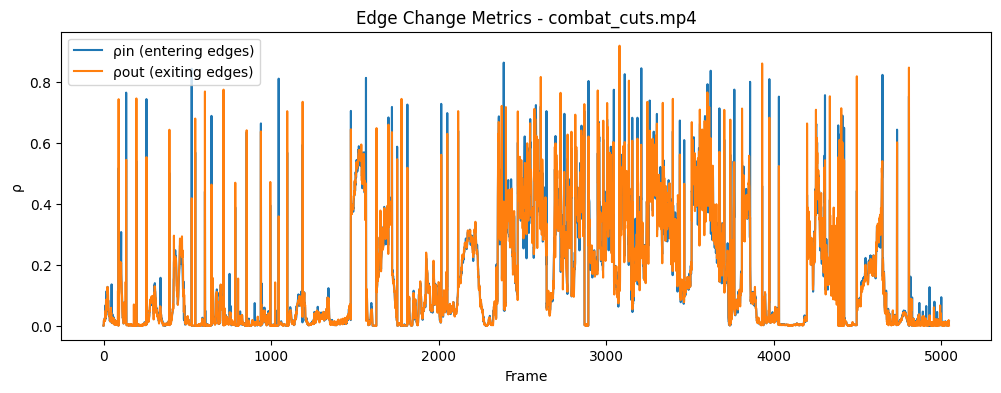

Processing 2015 frames for video drone_mouvement_canyon.mp4


100%|██████████| 2014/2014 [00:01<00:00, 1307.44it/s]


Video: drone_mouvement_canyon.mp4
Mean ρin: 0.2356, Mean ρout: 0.2354


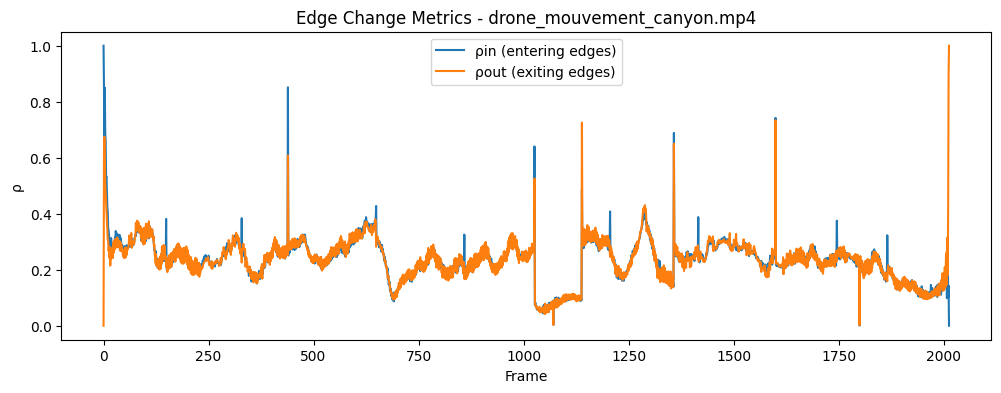

Processing 1389 frames for video fondu_enchaine_gony.mp4


100%|██████████| 1388/1388 [00:00<00:00, 1604.20it/s]


Video: fondu_enchaine_gony.mp4
Mean ρin: 0.0036, Mean ρout: 0.0058


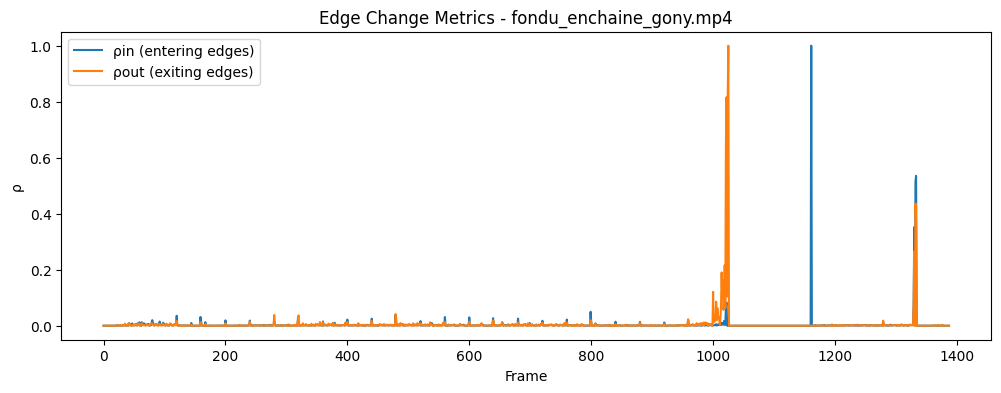

Processing 18278 frames for video tennis_plan_fixe.mp4


100%|██████████| 18277/18277 [00:14<00:00, 1253.23it/s]


Video: tennis_plan_fixe.mp4
Mean ρin: 0.0132, Mean ρout: 0.0132


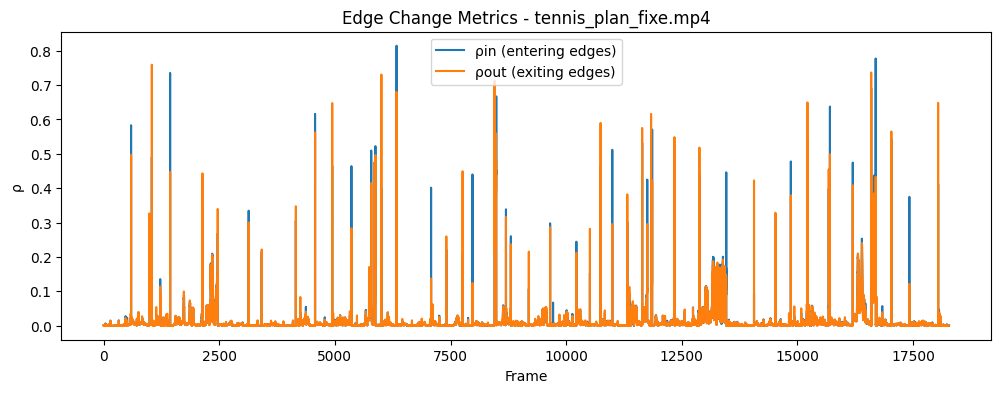

In [ ]:
def dilate_edges(edge_map, kernel_size=3):
    """Dilate edge map"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(edge_map, kernel)


for video_name, video_data in edges.items():
    edge_maps = video_data["edge_maps"]
    frame_count = edge_maps.shape[0]

    print(f"Processing {frame_count} frames for video {video_name.name}")

    rho_in_list = []
    rho_out_list = []

    for t in tqdm(range(frame_count - 1)):
        E_t = edge_maps[t]
        E_t1 = edge_maps[t + 1]

        D_t = dilate_edges(E_t)
        D_t1 = dilate_edges(E_t1)

        sum_E_t1 = np.sum(E_t1)
        if sum_E_t1 > 0:
            rho_in = 1 - np.sum(D_t & E_t1) / sum_E_t1
        else:
            rho_in = 0

        sum_E_t = np.sum(E_t)
        if sum_E_t > 0:
            rho_out = 1 - np.sum(E_t & D_t1) / sum_E_t
        else:
            rho_out = 0

        rho_in_list.append(rho_in)
        rho_out_list.append(rho_out)

    print(f"Video: {video_name.name}")
    print(
        f"Mean ρin: {np.mean(rho_in_list):.4f}, Mean ρout: {np.mean(rho_out_list):.4f}"
    )

    plt.figure(figsize=(12, 4))
    plt.plot(rho_in_list, label="ρin (entering edges)")
    plt.plot(rho_out_list, label="ρout (exiting edges)")
    plt.xlabel("Frame")
    plt.ylabel("ρ")
    plt.legend()
    plt.title(f"Edge Change Metrics - {video_name.name}")
    plt.show()


=== combat_cuts.mp4 ===
Cuts detected: 26 at frames [90, 135, 196, 256, 526, 605, 716, 1045, 1096, 1188, 1778, 1813, 2015, 2116, 2388, 2643, 3079, 3675, 3704, 3930, 3973, 4030, 4334, 4402, 4495, 4806]
Fades detected: 10 - [(1685, 1699), (2369, 2377), (2560, 2566), (2571, 2622), (2783, 2793), (2841, 2870), (3082, 3107), (3824, 3859), (4245, 4276), (4279, 4285)]
Gradations detected: 41 - [(1476, 1567), (1673, 1683), (1700, 1722), (2181, 2189), (2214, 2220), (2352, 2365), (2401, 2424), (2426, 2439), (2445, 2452), (2472, 2506), (2507, 2523), (2524, 2559), (2625, 2640), (2689, 2696), (2697, 2732), (2744, 2751), (2769, 2780), (2815, 2840), (2894, 2902), (2949, 2961), (2962, 2967), (2982, 2992), (2998, 3032), (3036, 3046), (3110, 3132), (3135, 3144), (3201, 3210), (3240, 3246), (3247, 3252), (3253, 3332), (3335, 3379), (3380, 3388), (3390, 3395), (3397, 3402), (3410, 3415), (3510, 3647), (3758, 3765), (3810, 3823), (4300, 4306), (4628, 4636), (4637, 4649)]


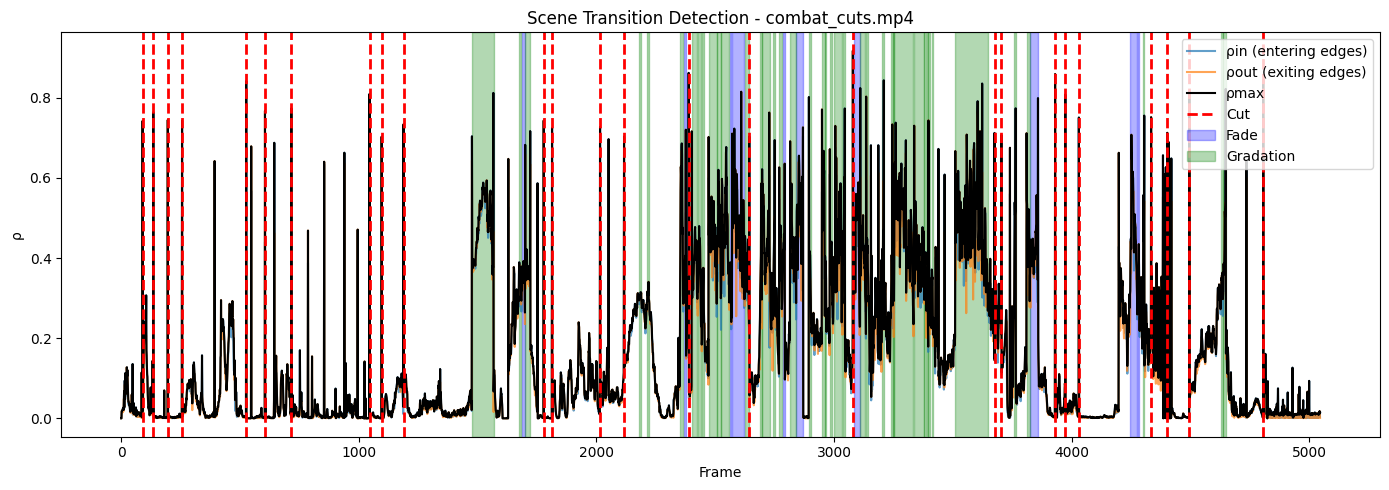


=== drone_mouvement_canyon.mp4 ===
Cuts detected: 2 at frames [439, 1600]
Fades detected: 1 - [(307, 323)]
Gradations detected: 13 - [(0, 15), (27, 42), (74, 120), (464, 482), (565, 570), (586, 658), (970, 978), (1139, 1145), (1146, 1180), (1186, 1202), (1274, 1305), (1441, 1448), (1469, 1492)]


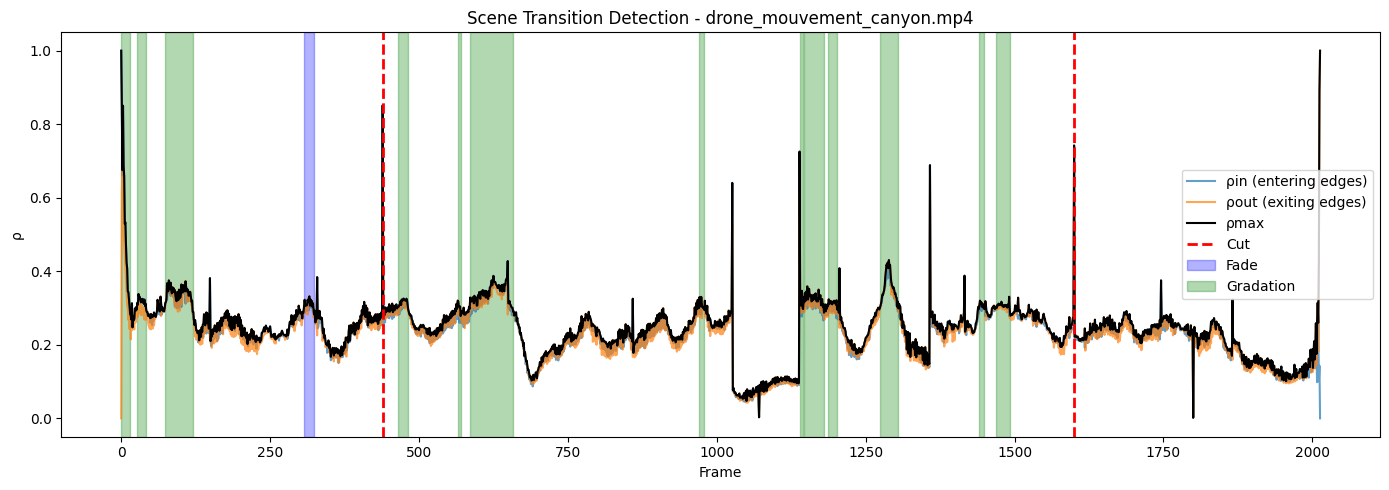


=== fondu_enchaine_gony.mp4 ===
Cuts detected: 1 at frames [1161]
Fades detected: 0 - []
Gradations detected: 0 - []


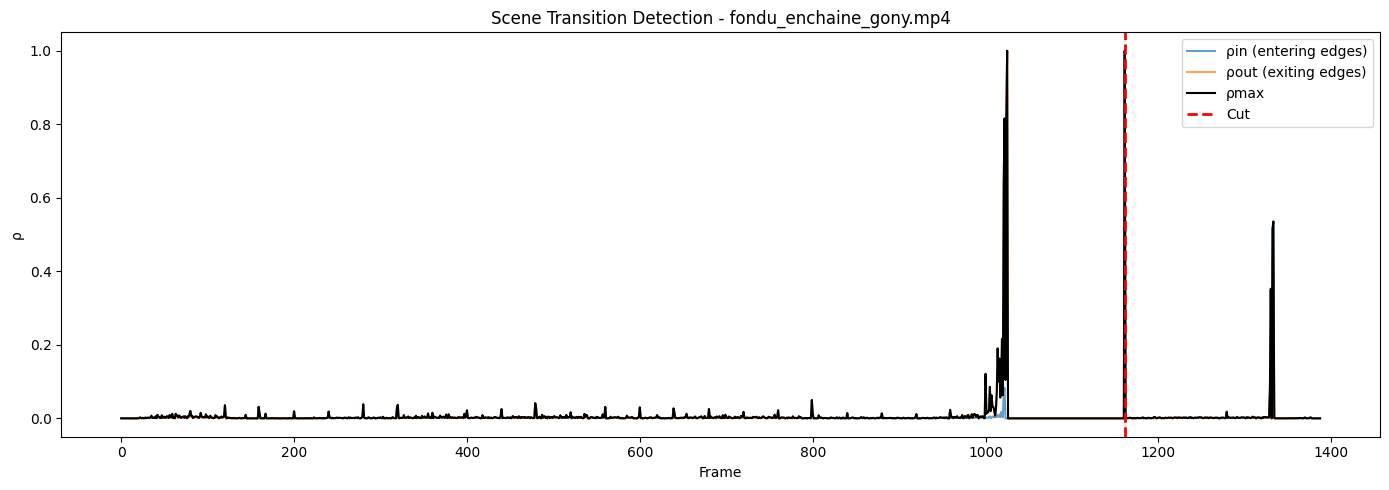


=== tennis_plan_fixe.mp4 ===
Cuts detected: 6 at frames [1044, 1439, 6006, 6334, 8450, 16691]
Fades detected: 0 - []
Gradations detected: 2 - [(8457, 8490), (16612, 16621)]


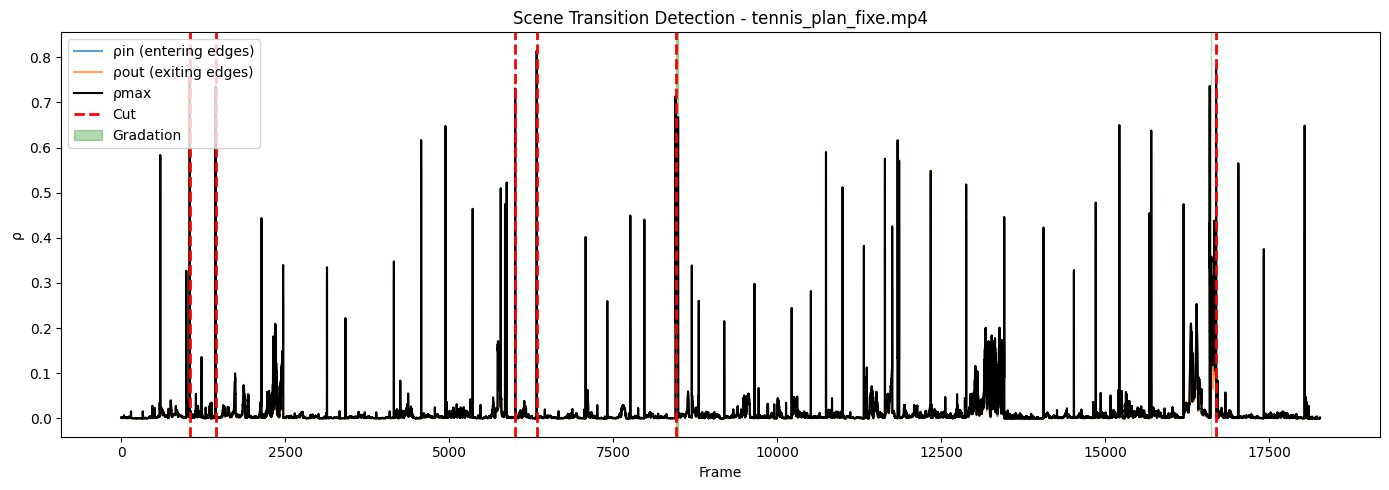

In [ ]:
def detect_transitions(
    rho_in_list, rho_out_list, cut_threshold=0.7, gradual_threshold=0.3, min_duration=5
):
    rho_in = np.array(rho_in_list)
    rho_out = np.array(rho_out_list)
    rho_max = np.maximum(rho_in, rho_out)

    cuts = []
    fades = []
    gradations = []

    for t in range(len(rho_max)):
        if rho_max[t] > cut_threshold:
            is_isolated = True
            if t > 0 and rho_max[t - 1] > gradual_threshold:
                is_isolated = False
            if t < len(rho_max) - 1 and rho_max[t + 1] > gradual_threshold:
                is_isolated = False
            if is_isolated:
                cuts.append(t)

    in_transition = False
    transition_start = 0

    for t in range(len(rho_max)):
        if not in_transition and rho_max[t] > gradual_threshold:
            in_transition = True
            transition_start = t
        elif in_transition and rho_max[t] <= gradual_threshold:
            in_transition = False
            duration = t - transition_start

            if duration >= min_duration:
                segment_in = rho_in[transition_start:t]
                segment_out = rho_out[transition_start:t]

                first_half = len(segment_in) // 2
                in_dominant_start = np.mean(segment_in[:first_half]) > np.mean(
                    segment_out[:first_half]
                )
                out_dominant_end = np.mean(segment_out[first_half:]) > np.mean(
                    segment_in[first_half:]
                )

                if in_dominant_start and out_dominant_end:
                    fades.append((transition_start, t))
                else:
                    gradations.append((transition_start, t))

    if in_transition and (len(rho_max) - transition_start) >= min_duration:
        t = len(rho_max)
        segment_in = rho_in[transition_start:t]
        segment_out = rho_out[transition_start:t]
        first_half = len(segment_in) // 2
        in_dominant_start = np.mean(segment_in[:first_half]) > np.mean(
            segment_out[:first_half]
        )
        out_dominant_end = np.mean(segment_out[first_half:]) > np.mean(
            segment_in[first_half:]
        )

        if in_dominant_start and out_dominant_end:
            fades.append((transition_start, t))
        else:
            gradations.append((transition_start, t))

    return cuts, fades, gradations


for video_name, video_data in edges.items():
    edge_maps = video_data["edge_maps"]
    frame_count = edge_maps.shape[0]

    rho_in_list = []
    rho_out_list = []

    for t in range(frame_count - 1):
        E_t = edge_maps[t]
        E_t1 = edge_maps[t + 1]
        D_t = dilate_edges(E_t)
        D_t1 = dilate_edges(E_t1)

        sum_E_t1 = np.sum(E_t1)
        rho_in = 1 - np.sum(D_t & E_t1) / sum_E_t1 if sum_E_t1 > 0 else 0

        sum_E_t = np.sum(E_t)
        rho_out = 1 - np.sum(E_t & D_t1) / sum_E_t if sum_E_t > 0 else 0

        rho_in_list.append(rho_in)
        rho_out_list.append(rho_out)

    cuts, fades, gradations = detect_transitions(rho_in_list, rho_out_list)

    print(f"\n=== {video_name.name} ===")
    print(f"Cuts detected: {len(cuts)} at frames {cuts}")
    print(f"Fades detected: {len(fades)} - {fades}")
    print(f"Gradations detected: {len(gradations)} - {gradations}")

    plt.figure(figsize=(14, 5))
    rho_max = np.maximum(rho_in_list, rho_out_list)

    plt.plot(rho_in_list, label="ρin (entering edges)", alpha=0.7)
    plt.plot(rho_out_list, label="ρout (exiting edges)", alpha=0.7)
    plt.plot(rho_max, label="ρmax", color="black", linewidth=1.5)

    for c in cuts:
        plt.axvline(
            x=c,
            color="red",
            linestyle="--",
            linewidth=2,
            label="Cut" if c == cuts[0] else "",
        )

    for i, (start, end) in enumerate(fades):
        plt.axvspan(start, end, alpha=0.3, color="blue", label="Fade" if i == 0 else "")

    for i, (start, end) in enumerate(gradations):
        plt.axvspan(
            start, end, alpha=0.3, color="green", label="Gradation" if i == 0 else ""
        )

    plt.xlabel("Frame")
    plt.ylabel("ρ")
    plt.legend()
    plt.title(f"Scene Transition Detection - {video_name.name}")
    plt.tight_layout()
    plt.show()

In [ ]:
DETECTION_THRESHOLD = 1
cuts_path = Path("./cuts")

detected_cuts = {}

for video_name, video_data in edges.items():
    edge_maps = video_data["edge_maps"]
    frame_count = edge_maps.shape[0]

    rho_in_list = []
    rho_out_list = []

    for t in range(frame_count - 1):
        E_t = edge_maps[t]
        E_t1 = edge_maps[t + 1]
        D_t = dilate_edges(E_t)
        D_t1 = dilate_edges(E_t1)

        sum_E_t1 = np.sum(E_t1)
        rho_in = 1 - np.sum(D_t & E_t1) / sum_E_t1 if sum_E_t1 > 0 else 0

        sum_E_t = np.sum(E_t)
        rho_out = 1 - np.sum(E_t & D_t1) / sum_E_t if sum_E_t > 0 else 0

        rho_in_list.append(rho_in)
        rho_out_list.append(rho_out)

    cuts, fades, gradations = detect_transitions(rho_in_list, rho_out_list)
    detected_cuts[video_name] = cuts

for video_name, gen_cuts in detected_cuts.items():
    name_file = video_name.name.split(".")[0]
    valid_cuts_path = cuts_path / f"{name_file}.txt"

    if not valid_cuts_path.exists():
        print(f"Ground truth file not found: {valid_cuts_path}")
        continue

    with open(valid_cuts_path, "r") as f:
        valid_cuts_str = f.read()

    valid_cuts = []
    for x in valid_cuts_str.split(","):
        stripped = x.strip()
        if stripped.isdigit():
            valid_cuts.append(int(stripped))

    correct_cuts = []
    incorrect_cuts = []

    for gc in gen_cuts:
        found = False
        for vc in valid_cuts:
            if abs(gc - vc) <= DETECTION_THRESHOLD:
                found = True
                break
        if found:
            correct_cuts.append(gc)
        else:
            incorrect_cuts.append(gc)

    total_detected = len(gen_cuts)
    if total_detected > 0:
        pct_correct = len(correct_cuts) / total_detected * 100
        pct_incorrect = len(incorrect_cuts) / total_detected * 100
    else:
        pct_correct = 0.0
        pct_incorrect = 0.0

    if valid_cuts:
        missed_cuts = []
        for vc in valid_cuts:
            detected = any(abs(gc - vc) <= DETECTION_THRESHOLD for gc in gen_cuts)
            if not detected:
                missed_cuts.append(vc)
        recall = (len(valid_cuts) - len(missed_cuts)) / len(valid_cuts) * 100
    else:
        missed_cuts = []
        recall = 0.0

    print(f"\n{'=' * 50}")
    print(f"Vidéo: {video_name.name}")
    print(f"{'=' * 50}")
    print(f"Cuts détectés: {total_detected} | Ground truth: {len(valid_cuts)}")
    print(f"\n✓ Détections correctes: {len(correct_cuts)} ({pct_correct:.1f}%)")
    print(f"  Frames: {correct_cuts}")
    print(f"\n✗ Faux positifs: {len(incorrect_cuts)} ({pct_incorrect:.1f}%)")
    print(f"  Frames: {incorrect_cuts}")
    print(f"\n⊘ Cuts manqués: {len(missed_cuts)} ({100 - recall:.1f}% du ground truth)")
    print(f"  Frames: {missed_cuts}")
    print(f"\nRappel: {recall:.1f}%")


Vidéo: combat_cuts.mp4
Cuts détectés: 26 | Ground truth: 77

✓ Détections correctes: 23 (88.5%)
  Frames: [135, 196, 256, 526, 605, 716, 1045, 1096, 1188, 1778, 1813, 2015, 2116, 2388, 2643, 3079, 3675, 3704, 3930, 3973, 4030, 4334, 4495]

✗ Faux positifs: 3 (11.5%)
  Frames: [90, 4402, 4806]

⊘ Cuts manqués: 54 (70.1% du ground truth)
  Frames: [393, 547, 644, 786, 854, 939, 995, 1476, 1566, 1629, 1700, 1721, 1752, 2051, 2377, 2401, 2472, 2571, 2609, 2697, 2727, 2750, 2769, 2792, 2815, 2869, 2894, 2949, 2982, 3005, 3045, 3110, 3135, 3155, 3186, 3209, 3245, 3302, 3337, 3397, 3439, 3465, 3510, 3623, 3740, 3764, 3810, 3858, 4198, 4251, 4384, 4419, 4648, 4735]

Rappel: 29.9%

Vidéo: drone_mouvement_canyon.mp4
Cuts détectés: 2 | Ground truth: 3

✓ Détections correctes: 0 (0.0%)
  Frames: []

✗ Faux positifs: 2 (100.0%)
  Frames: [439, 1600]

⊘ Cuts manqués: 3 (100.0% du ground truth)
  Frames: [1026, 1139, 1358]

Rappel: 0.0%

Vidéo: fondu_enchaine_gony.mp4
Cuts détectés: 1 | Ground truth